In [1]:
import torch
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import argparse,os,time
import os
import time
import seaborn as sns
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="3"
num_gpus=4

In [2]:
mean=np.load('mean.npy').tolist()
std=np.load('std.npy').tolist()
mean_test=np.load('mean_test.npy').tolist()
std_test=np.load('std_test.npy').tolist()

In [3]:
class CustomDataset(Dataset):
    def __init__(self,path):
        xy = np.loadtxt(path,
                        delimiter=',', dtype=np.float32)
        self.len = xy.shape[0]
        self.x_data = torch.tensor(xy[:, 0:5])
        xy=xy.astype('int_')
        self.y_data = torch.tensor(xy[:, 5])

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [4]:
batch_size=300
train_dataset = CustomDataset('norm_data_train_uniform_ext.csv')
train_loader = DataLoader(dataset=train_dataset,pin_memory=True,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=60,drop_last=True)
test_dataset = CustomDataset('norm_data_test_uniform_ext.csv')
test_loader = DataLoader(dataset=test_dataset,pin_memory=True,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=60,drop_last=True)

In [5]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(5, 40),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(40, 40),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(40, 40),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(40, 40),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(40, 40),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(40, 40),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(40, 40),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        x=x.view(batch_size//num_gpus,-1)
        out=self.fc(x)
        return out

In [6]:
model=nn.DataParallel(Model().cuda())

# model=(nn.Sequential(model_start,model_temp,model_fin)).cuda()   
if torch.cuda.is_available():
    model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
for epoch in range(100):
    for idx, data in enumerate(train_loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs=inputs.cuda()
            labels=labels.cuda()
        output= model(inputs)
        optimizer.zero_grad()
        loss=criterion(output, labels)
        loss.backward()
        optimizer.step()
    print('epoch {}, loss {}, idx {}'.format(epoch, loss.item(),idx))
    now = time.localtime()
    print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))


epoch 0, loss 0.040395114570856094, idx 999
2020/12/15 03:50:17
epoch 1, loss 0.042728349566459656, idx 999
2020/12/15 03:50:42
epoch 2, loss 0.0888364315032959, idx 999
2020/12/15 03:51:07
epoch 3, loss 0.016681160777807236, idx 999
2020/12/15 03:51:31
epoch 4, loss 0.02618062123656273, idx 999
2020/12/15 03:51:56
epoch 5, loss 0.03955575451254845, idx 999
2020/12/15 03:52:21
epoch 6, loss 0.06266990303993225, idx 999
2020/12/15 03:52:46
epoch 7, loss 0.014678397215902805, idx 999
2020/12/15 03:53:10
epoch 8, loss 0.014126570895314217, idx 999
2020/12/15 03:53:35
epoch 9, loss 0.06889980286359787, idx 999
2020/12/15 03:53:59
epoch 10, loss 0.007398219313472509, idx 999
2020/12/15 03:54:24
epoch 11, loss 0.03702089190483093, idx 999
2020/12/15 03:54:49
epoch 12, loss 0.03935534879565239, idx 999
2020/12/15 03:55:13
epoch 13, loss 0.03987869247794151, idx 999
2020/12/15 03:55:38
epoch 14, loss 0.009469350799918175, idx 999
2020/12/15 03:56:03
epoch 15, loss 0.024872785434126854, idx 999

In [7]:
target_temp=np.zeros(1)
output_temp=np.zeros(1)
input_temp=np.zeros((1,5))
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        _, predicted=torch.max(output,1)
        target_temp=np.hstack([target_temp,target.cpu().numpy()])
        output_temp=np.hstack([output_temp,predicted.cpu().numpy()])
        input_temp=np.vstack([input_temp,data.cpu().numpy()])
target_temp=np.delete(target_temp,0)
output_temp=np.delete(output_temp,0)
input_temp=np.delete(input_temp,0,axis=0)

In [8]:
correct = 0
for i in range(len(output_temp)):
    correct += (output_temp[i] == target_temp[i])

print('Accuracy of the network: %d %%' % (
    100 * correct /len(output_temp)))

Accuracy of the network: 99 %


In [9]:
correct_d=0
tot_d=0
correct_u=0
tot_u=0
correct_s=0
tot_s=0
for i in range(len(output_temp)):
    if(target_temp[i]==1):
        correct_d += (output_temp[i] == target_temp[i])
        tot_d += 1
        
    if(target_temp[i]==0):
        correct_s += (output_temp[i] == target_temp[i])
        tot_s += 1
        
    if(target_temp[i]==2):
        correct_u += (output_temp[i] == target_temp[i])
        tot_u += 1

print('Accuracy of the network control down: %d %%' % (
    100 * correct_d /tot_d))
print('Accuracy of the network control stay: %d %%' % (
    100 * correct_s /tot_s))
print('Accuracy of the network control up: %d %%' % (
    100 * correct_u /tot_u))

Accuracy of the network control down: 99 %
Accuracy of the network control stay: 99 %
Accuracy of the network control up: 98 %


In [10]:
con_mat=np.zeros((3,3))
con_mat[0,0]

0.0

[[29877.   123.     0.]
 [   74. 29852.    74.]
 [  215.   221. 29564.]]


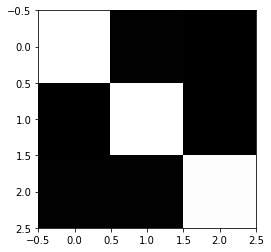

In [11]:
con_mat=np.zeros((3,3))
con_mat2=np.zeros((2,2))
tot_d=0
tot_u=0
tot_s=0
for i in range(len(output_temp)):
    if(target_temp[i]==1):
        tot_d += 1
        if (output_temp[i]==1):
            con_mat[0,0]+=1
        if (output_temp[i]==0):
            con_mat[0,1]+=1
        if (output_temp[i]==2):
            con_mat[0,2]+=1
        
    if(target_temp[i]==0):
        tot_s += 1
        if (output_temp[i]==1):
            con_mat[1,0]+=1
        if (output_temp[i]==0):
            con_mat[1,1]+=1
        if (output_temp[i]==2):
            con_mat[1,2]+=1
        
    if(target_temp[i]==2):
        tot_u += 1
        if (output_temp[i]==1):
            con_mat[2,0]+=1
        if (output_temp[i]==0):
            con_mat[2,1]+=1
        if (output_temp[i]==2):
            con_mat[2,2]+=1
        
plt.imshow(con_mat,cmap="gray")
print(con_mat)
con_mat2[0,0]=np.sum(con_mat[0:3:2,0:3:2])
con_mat2[0,1]=np.sum(con_mat[0:3:2,1])
con_mat2[1,0]=np.sum(con_mat[1,0:3:2])
con_mat2[1,1]=np.sum(con_mat[1,1])

In [12]:
df_cm = pd.DataFrame(con_mat, index = ['down','stay','up'],
                  columns = ['down','stay','up'])

<AxesSubplot:>

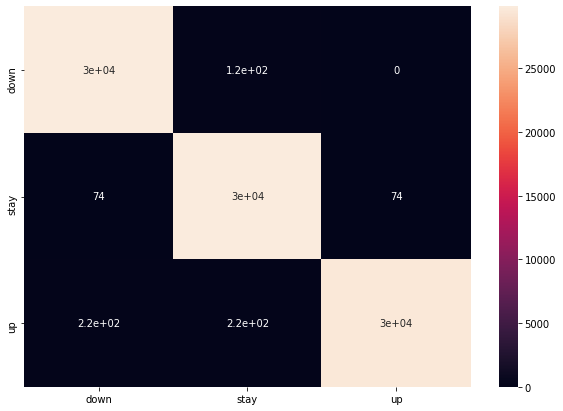

In [13]:
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

[[59656.   344.]
 [  148. 29852.]]


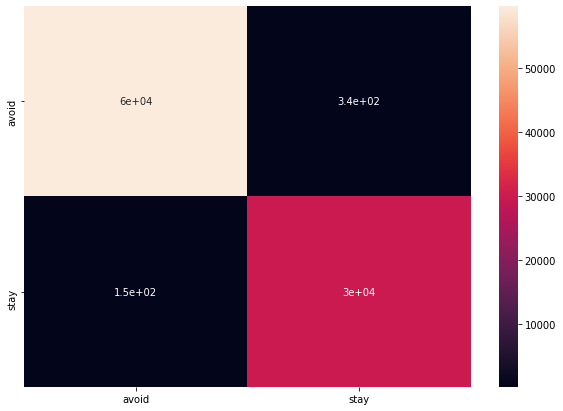

In [14]:
df_cm = pd.DataFrame(con_mat2, index = ['avoid','stay'],
                  columns = ['avoid','stay'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
print(con_mat2)

In [15]:
torch.save(model.state_dict(), "train_res_fin")